In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys
sys.path.append('/Users/earnric/Google Drive/ASU/Codes/PythonCode/modules')
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import FuncFormatter
# from matplotlib.colors import LogNorm
import numpy as np
import math as ma
from subprocess import call

from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
import astropy 

from scipy.io import readsav
from scipy.interpolate import interp1d
# from scipy.interpolate import interp2d

import extinction
import igm

import loadSP as lsp
import cosmo
import halos
# import logInterp 

plt.rcParams['figure.figsize'] = (13,11)
plt.rcParams['font.size'] = 32
import gc

plt.rcParams.update({'font.size': 22, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})


In [3]:
def log_formatter(x,pos):
    return format(np.log10(x), '.0f')

def div_formatter(x,pos):
    return format(x/1000, '.1f')

def GHzFormatter(x,pos):
    return format(x/1e9, '.2e')
GHzfmt  = FuncFormatter(GHzFormatter)
divfmt  = FuncFormatter(div_formatter)
logfmt  = FuncFormatter(log_formatter)
nullfmt = NullFormatter()

In [28]:
# Cosmology from my paper
myCosmo = FlatLambdaCDM(H0=71.0, Om0=0.267, Ob0=0.0449, name='myCosmo')
comovingBox = 12.0 # per h

# Make sure we have halo information for this z... hop/...
num = 65 # This is the output_00num file that has the "info_" for finding the boxsize... see map above.
z   = 11.0

boxsizekpc = (comovingBox * u.Mpc/(1.0+z)/0.71).to(u.kpc)
print("Using cosmology: physical size  = {:.3f}".format(boxsizekpc))

sizeKeys = np.loadtxt('zKeysForSPfiles.txt',skiprows=1)
print("Physical Boxsize from kKey file = {:.3f}".format(sizeKeys[sizeKeys[::,0] == z][0,1] * u.kpc))

boxInCm = (12.0 /0.71/(1.0+z)) * 3.08e24 * u.cm
boxInKpc = boxInCm.to(u.kpc)
print("Using ramses const Mpc to CM    = {:.3f}:".format(boxInKpc) )

boxsizekpc = boxInKpc.value

boxInMpc = (12.0 /0.71/(1.0+z)) * u.Mpc
boxInCm = boxInMpc /3.08e14 * u.cm / u.Mpc
boxinKpc = boxInCm.to(u.kpc)
print("Using ramses const other way    = {:.3f}:".format(boxInKpc) )

# infoSize = 0.289213589861747e25 * u.cm
# print("Using info size, astro convert  = {:.3f}:".format(infoSize.to(u.kpc)) )
# print("Using info size, 3.08           = {:.3f}:".format(infoSize/(3.08e21 * u.cm/u.kpc)) )

print("Size in CM   = {:.4e}:".format((12.0 * u.Mpc/0.71/(1.0+z)).to(u.cm)) )
print("Info file CM = {:.4e}:".format(infoSize) )

#########################################
# The one to use... 
#########################################

rho_critDMz = myCosmo.critical_density(z) * myCosmo.Odm(z)
print('rho_crit_dm,z = {:.3e}'.format(rho_critDMz))

gc.collect()

Using cosmology: physical size  = 1408.451 kpc
Physical Boxsize from kKey file = 1406.000 kpc
Using ramses const Mpc to CM    = 1405.859 kpc:
Using ramses const other way    = 1405.859 kpc:
Size in CM   = 4.3460e+24 cm:
Info file CM = 2.8921e+24 cm:
rho_crit_dm,z = 3.634e-27 g / cm3


22

In [5]:
Odm = 0.222 # Om - Ob = Odm
h0  = 0.71
rho0 = myCosmo.critical_density0 * Odm # rho0 * O_DM --- Crit density in DM TODAY... Need to scale to redshift.
rho0/Odm
# Check critical density 'today' - Looks correct!

<Quantity 9.469372730554712e-30 g / cm3>

In [6]:
dmPartMass = 5.589e5 * u.Msun
print("DM particle mass {:.2f}".format(dmPartMass))
def totMass(numParts):
    return dmPartMass * numParts

DM particle mass 558900.00 solMass


In [7]:
locsRaw, mass, bt, Z, PZ, PPF = lsp.loadSP(z)
##############################################
# Need to correct the Z and PZ for the pristine
# fraction of the SP... 
##############################################
fpol = 1.0-PPF
fpol[fpol < 1e-5] = 0.0 # Don't form polluted stars when fpol is very small

Z_corr = Z/fpol
Z_corr[np.isinf(Z_corr)] = 0.9e-5 # Make the Z of the particles < Z_crit (1e-5)
Z_corr[Z_corr < 1e-5]    = 0.9e-5 # Place them all just below Z_crit
gc.collect()

/Users/earnric/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in divide


36

In [29]:
# Convert to comoving kpc ... we've divided out the h here so we have units of kpc
locs = (locsRaw/boxsizekpc) * comovingBox # Comoving coords of SPs 

In [20]:
# Compute age of the star particles...
# spAges is in Myr ... 

baseAge = cosmo.ageAtz(71,z) # ageAtZ return Myr, parameters are H and z
print("base age {:.2f}".format(baseAge))
spAges = baseAge - bt/1e6    # bt from SP file is in yr, convert to Myr... 
print("min sp age {:.2f} Myr".format(min(spAges)))
print("max sp age {:.2f} Myr".format(max(spAges)))
print("min sp Z {:.2e} Solar".format(min(Z)))
print("max sp Z {:.2e} Solar".format(max(Z)))
print("max sp Z {:.2e} mass frac".format(max(Z) * 0.02))

base age 426.38
min sp age 0.10 Myr
max sp age 273.83 Myr
min sp Z 5.00e-09 Solar
max sp Z 7.16e-01 Solar
max sp Z 1.43e-02 mass frac


In [21]:
arcPerKpc = myCosmo.arcsec_per_kpc_comoving(z=z)
print('Comoving @ {}, {:.4f}:'.format(z,arcPerKpc))
arcPerKpc = myCosmo.arcsec_per_kpc_proper(z=z)
print('Proper to {}, {:.4f}:'.format(z,arcPerKpc))
print('Proper to {}, {:.4f}:'.format(z,1/arcPerKpc))

kpcPerArcSec = cosmo.arcAtz(71,z=z,om=0.267) # size of an arcsec at the specified reshift in kpc
print('My Comoving @ {}, {:.4f}:'.format(z,arcPerKpc/(1+z)))
print('My Proper to {}, {:.4f}:'.format(z,arcPerKpc))
print('My Proper to {}, {:.4f}:'.format(z,1/arcPerKpc))

Comoving @ 11.0, 0.0208 arcsec / kpc:
Proper to 11.0, 0.2498 arcsec / kpc:
Proper to 11.0, 4.0026 kpc / arcsec:
My Comoving @ 11.0, 0.0208 arcsec / kpc:
My Proper to 11.0, 0.2498 arcsec / kpc:
My Proper to 11.0, 4.0026 kpc / arcsec:


In [22]:
myCosmo.age(z)

<Quantity 0.4251220556935174 Gyr>

In [12]:
##
## Load the halo locations
## hop halo pos file key:    #   npart,mass,cont.frac,xc,yc,zc,uc,vc,wc
## Scale locations to co-moving coordates

## THESE HALOS ARE BASED ON STAR PARTICLE LOCATIONS ##
##
prefix = '/Users/earnric/Research/RAMSES-Data/12Mpc-n.48-eps20/12Mpc-n.48-eps20-output/'
halosRawPos = lsp.loadHaloGrps(num,prefix=prefix+'hopStarData/') # Returns positions normalized to (-0.5, 0.5)
halossizes = lsp.loadHaloSizes(num,prefix=prefix+'hopStarData/') # Returns positions normalized to (-0.5, 0.5)
# halosRawPos = lsp.loadHaloGrps(num) # Returns positions normalized to (-0.5, 0.5)
# halossizes = lsp.loadHaloSizes(num) # Returns positions normalized to (-0.5, 0.5)

#halosPos = halosRawPos * boxsizekpc
halosPos = halosRawPos * comovingBox  # Comoving box 
print("Num of halos @ {} = {}".format(z,len(halosRawPos)))

Num of halos @ 11.0 = 1835


<Quantity 1405.8591847277253 kpc>

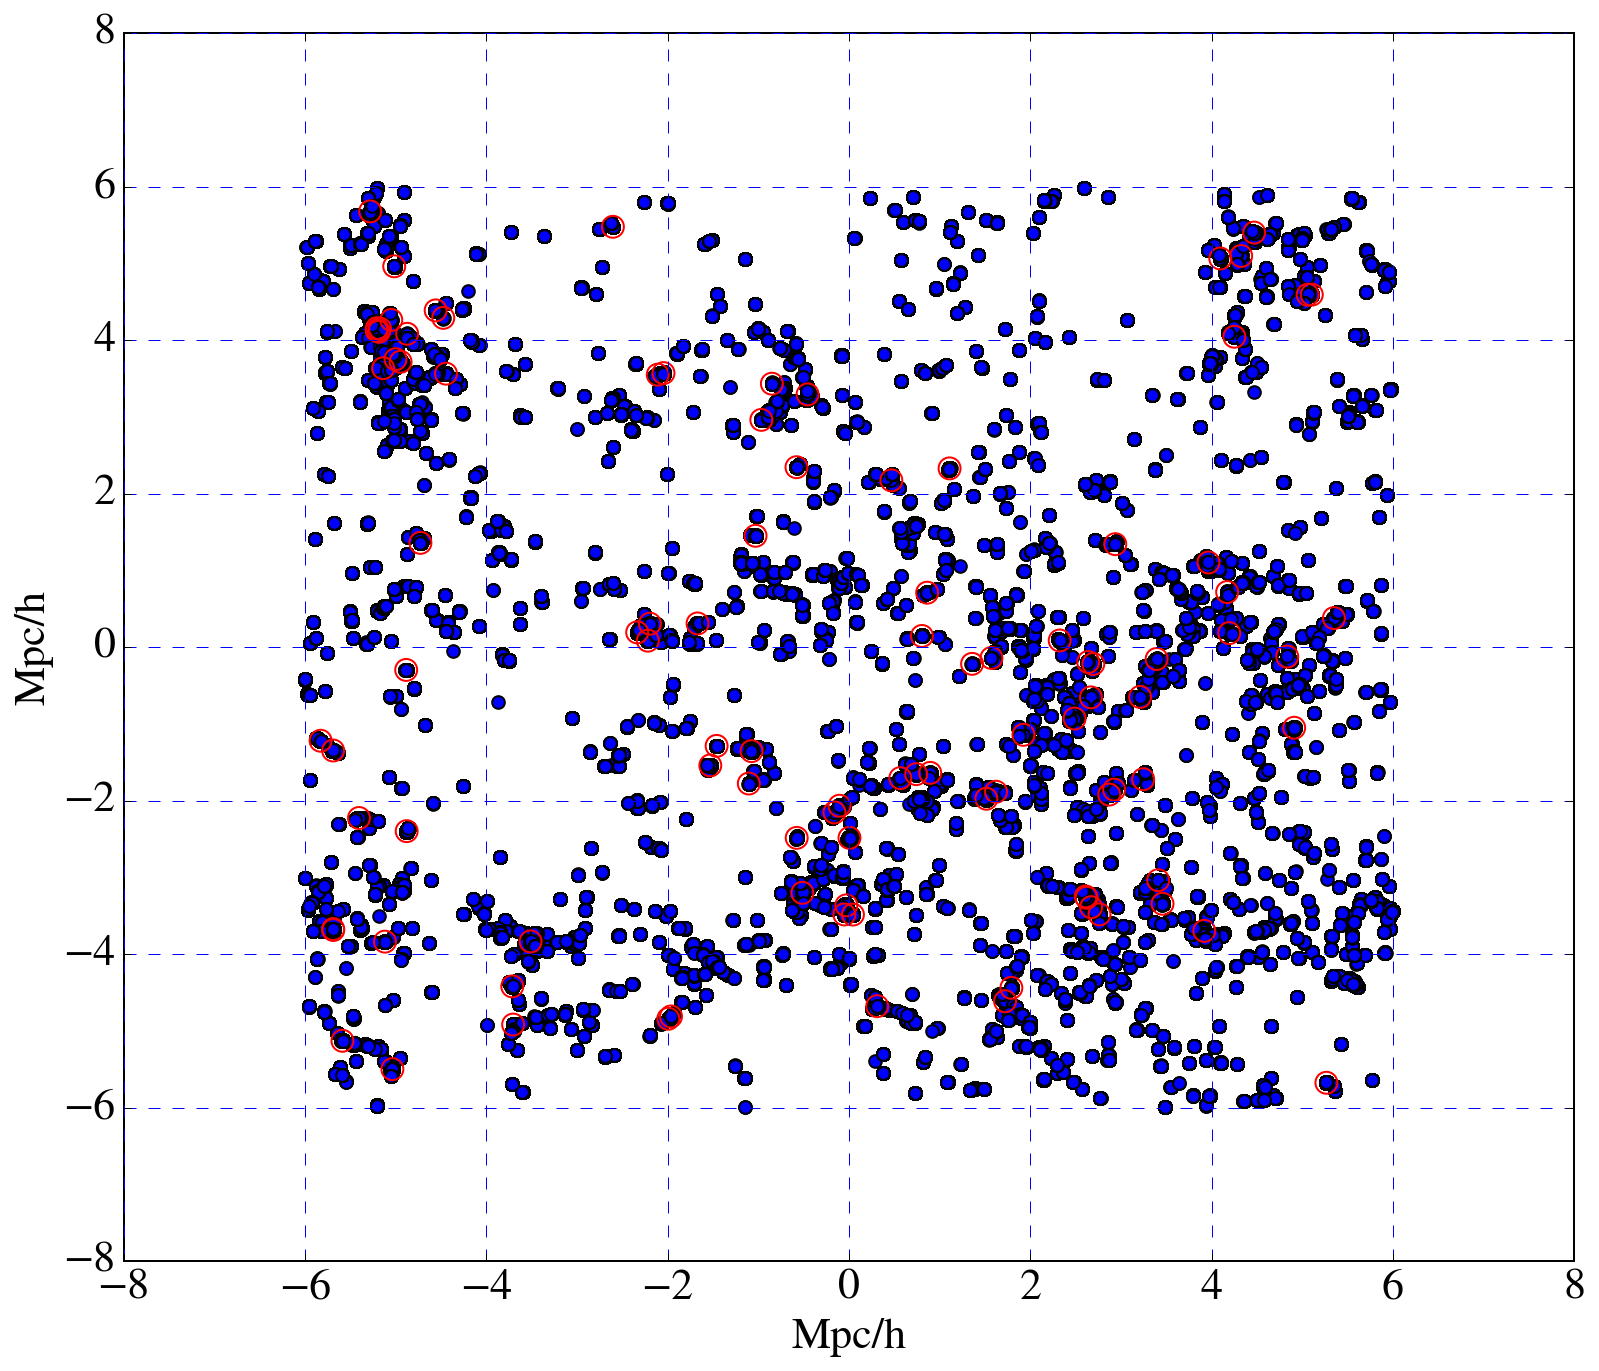

4483

In [25]:
# COORDINATES ARE COMOVING MPC / H
htp = min(100,len(halosRawPos))
labels = ['halo{0}'.format(i+1) for i in range(len(halosPos))]
plt.scatter(locs[:,0],locs[:,1],s=40,c='b') # Plot star particles
plt.scatter(halosPos[:htp,0],halosPos[:htp,1],s=120,facecolors='none', edgecolors='r') # Plot halo locs
plt.grid(b=True, which='major', color='b', linestyle='--')
plt.xlabel('Mpc/h')
plt.ylabel('Mpc/h')
# plt.xlim([-2,2])
# plt.ylim([-2,2])
# plt.title('z=%.1lf stars & halo finder'%z)
# for label, x, y in zip(labels, halosPos[:htp,0][:33],halosPos[:htp,1][:33]):
#     plt.annotate(
#         label, 
#         xy = (x, y), xytext = (-20, 20),
#         textcoords = 'offset points', ha = 'right', va = 'bottom',fontsize=10,
#         bbox = dict(boxstyle = 'round,pad=0.05', fc = 'yellow', alpha = 0.5),
#         arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
plt.show()
gc.collect()
 

In [37]:
halomass.size

1454132

radius 13.26
Halo mass 0 is 5.57e+09
radius 9.67
Halo mass 1 is 5.57e+09
radius 9.11
Halo mass 2 is 5.57e+09
radius 8.70
Halo mass 3 is 5.57e+09
radius 8.69
Halo mass 4 is 5.57e+09


36270

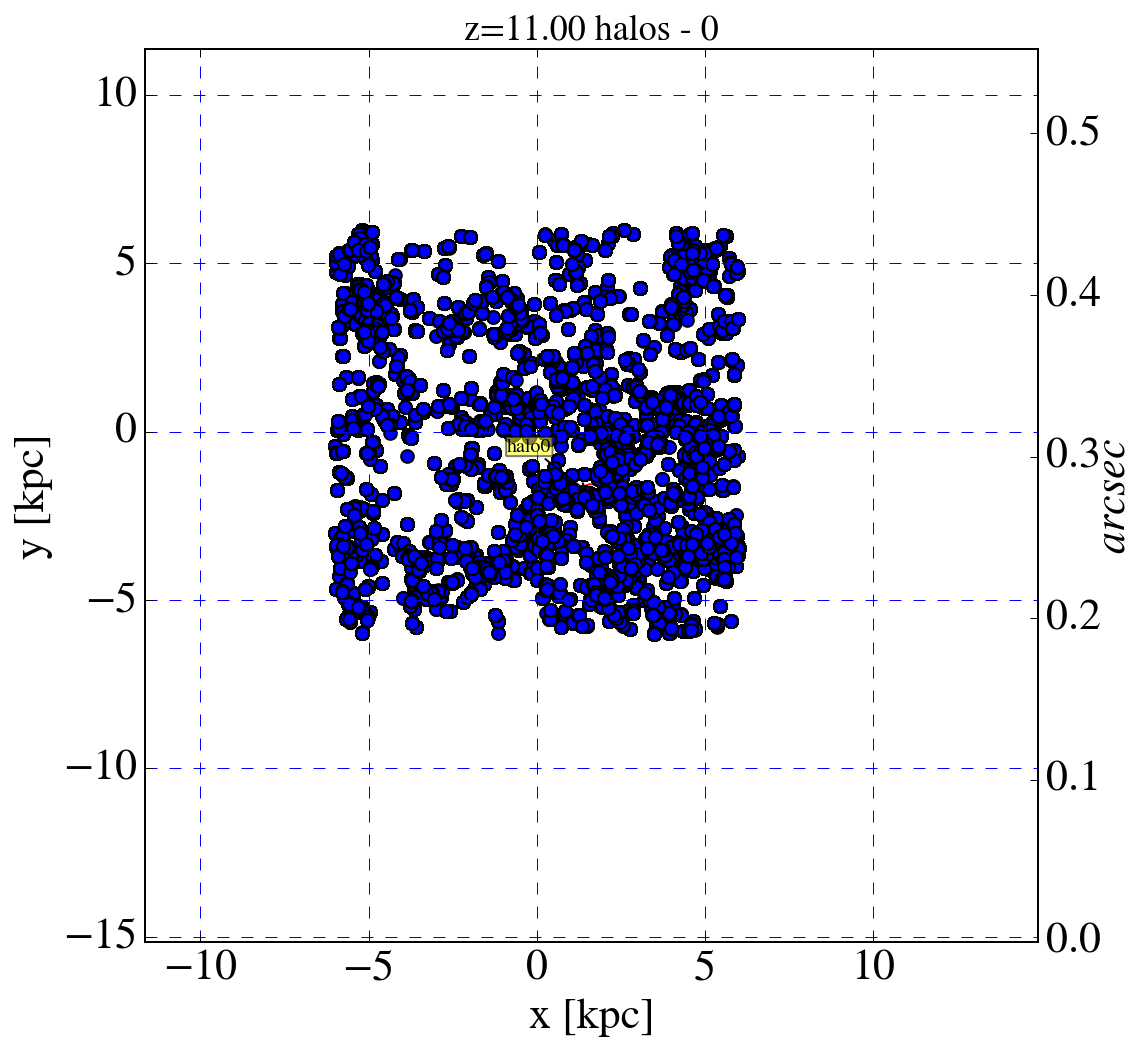

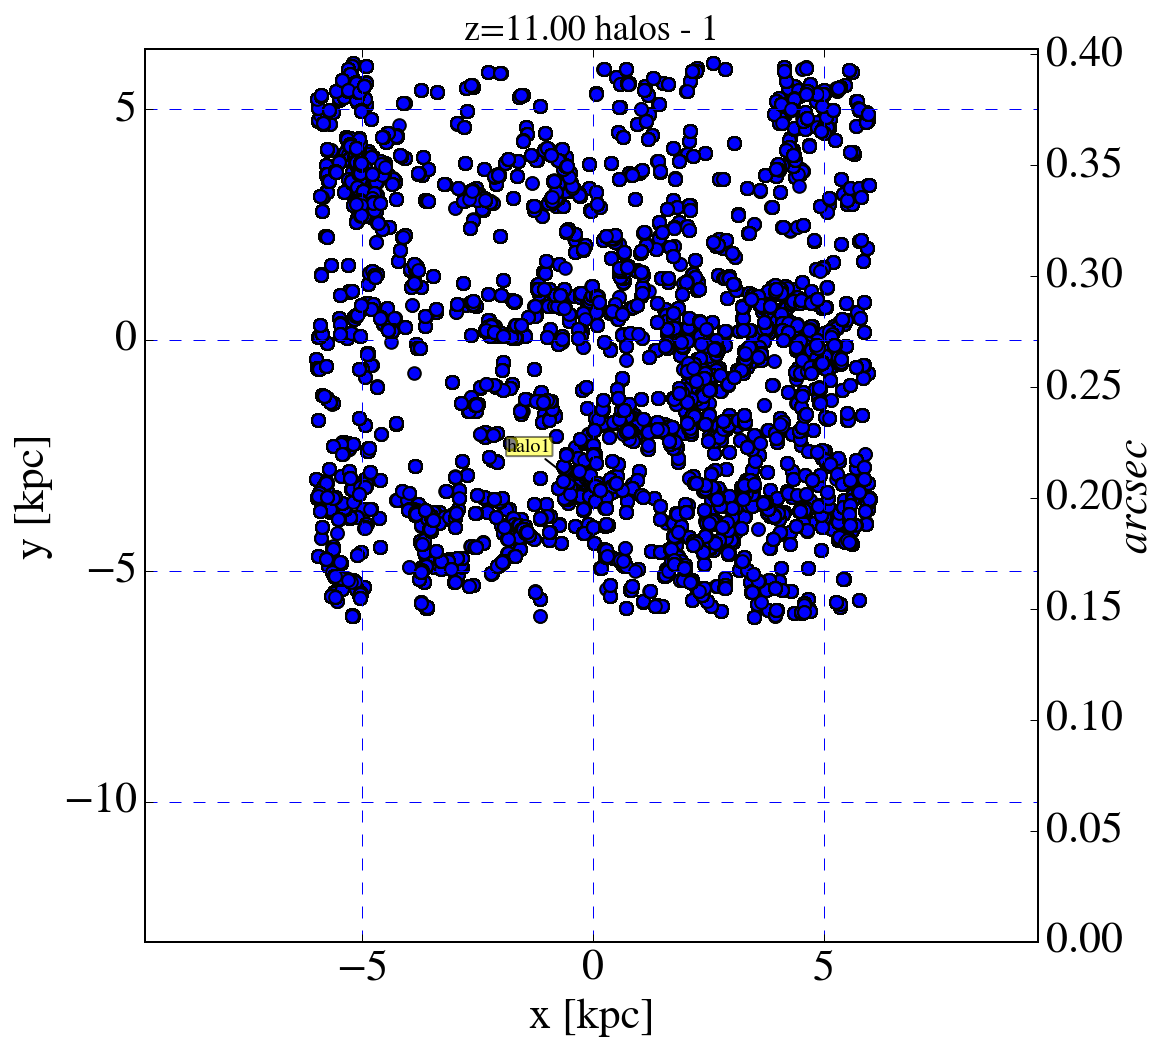

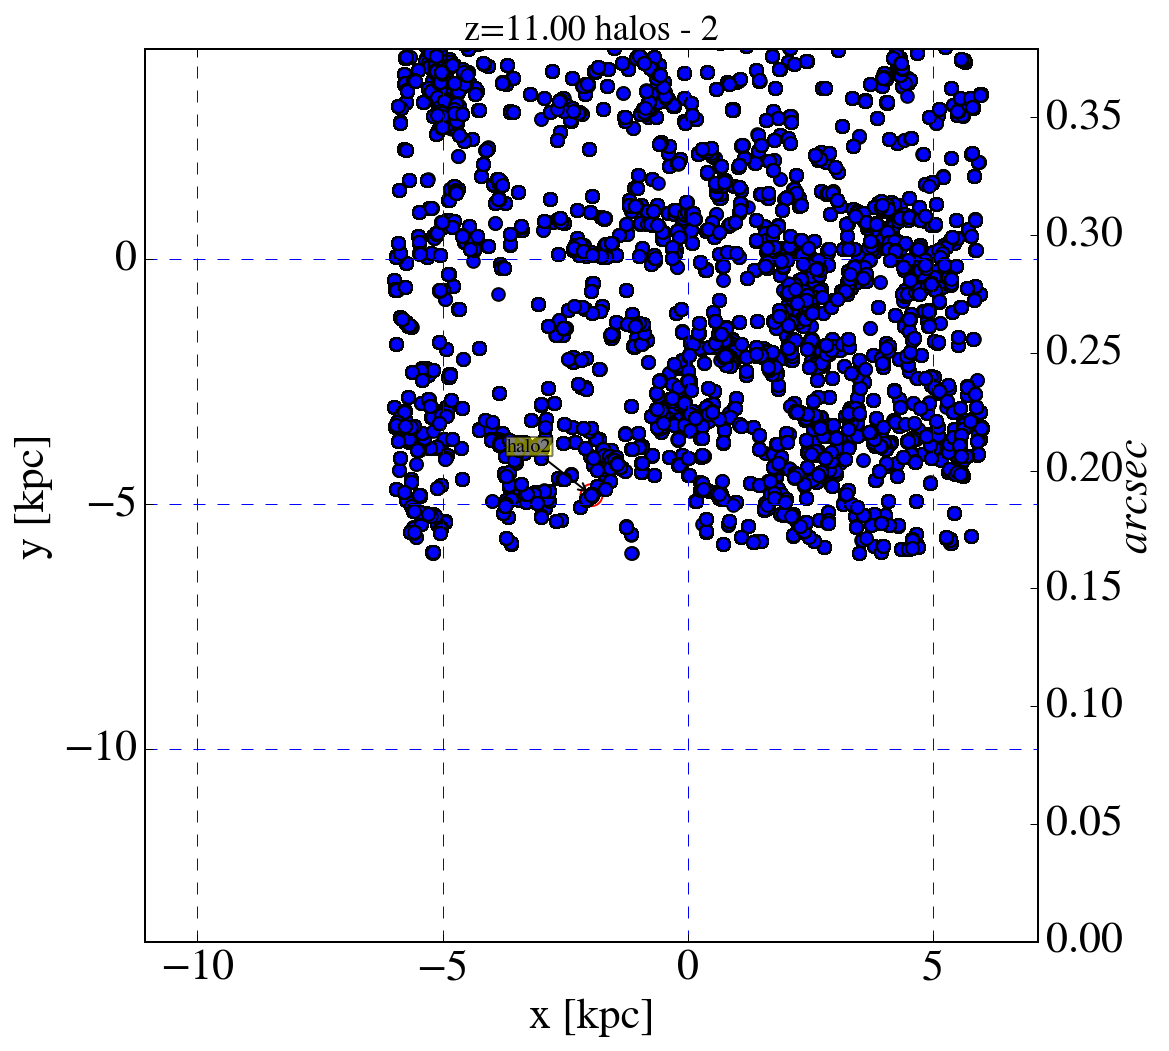

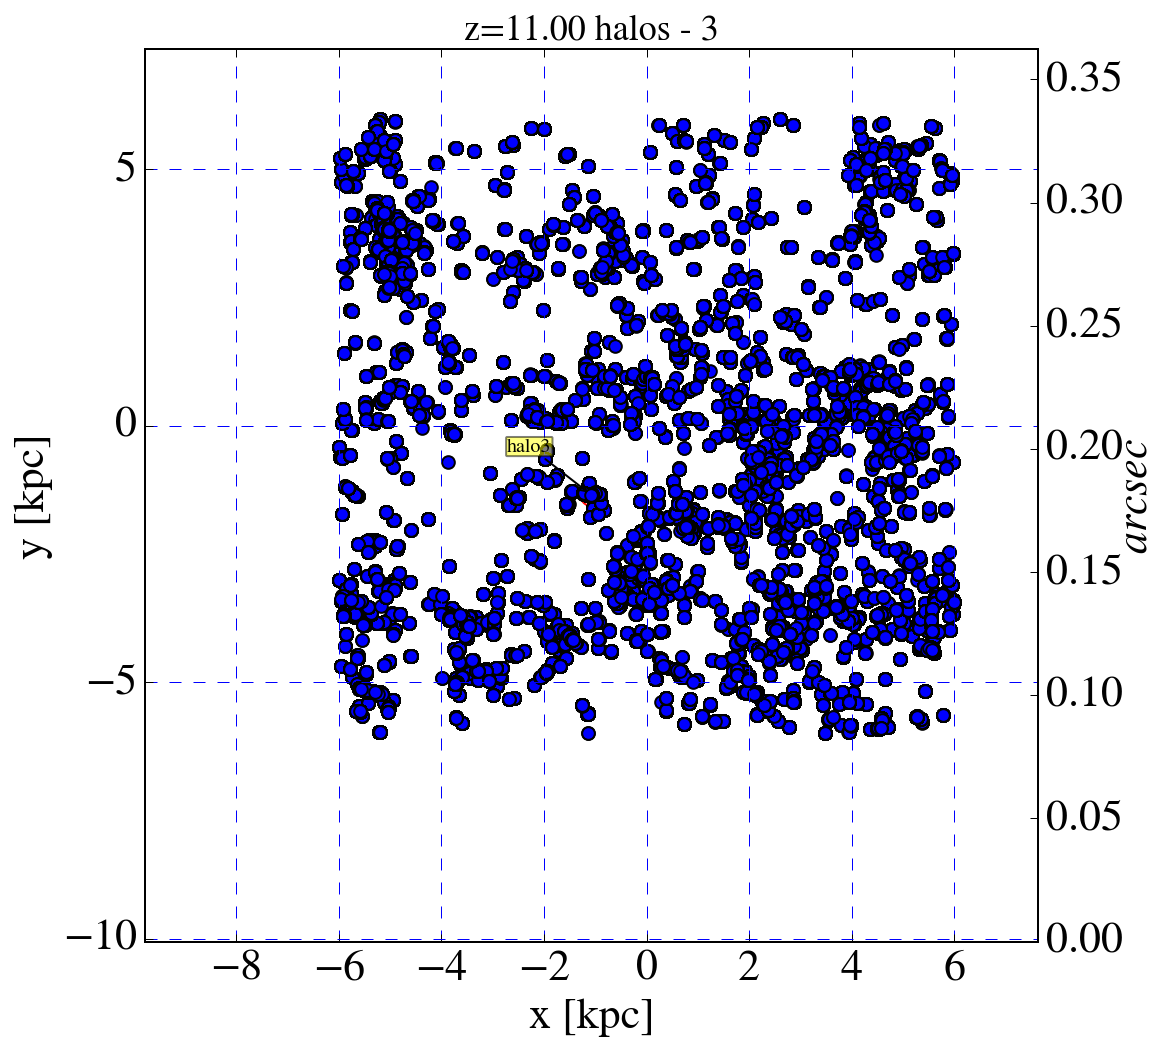

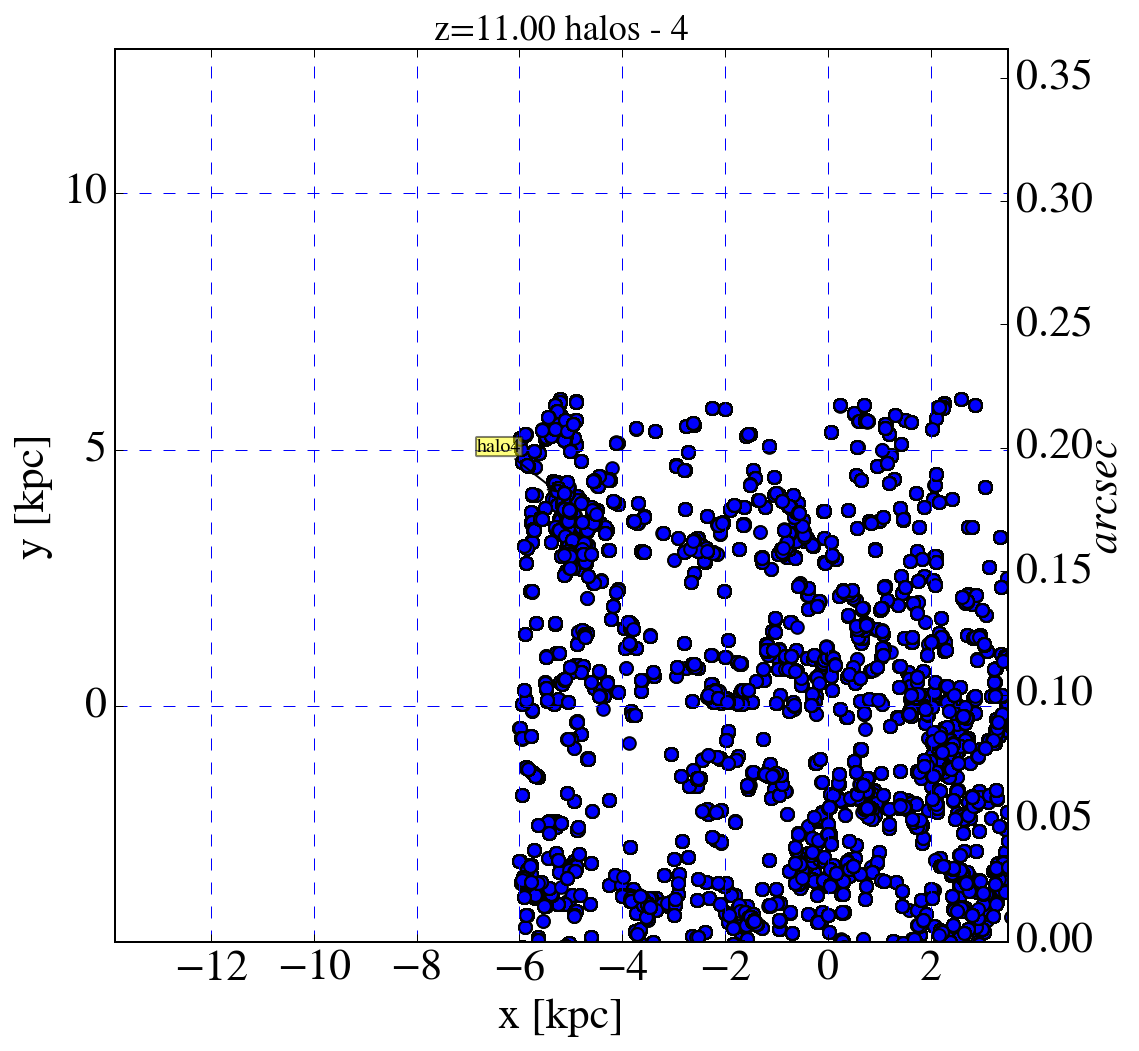

In [32]:
#######
# This plots a view... so stuff behind is included
#######

fig = plt.figure(figsize=(8,8))
for halo in range(0,5):
    arcSec_per_kpc_comov = myCosmo.arcsec_per_kpc_comoving(z=z).value 
    radiusScaleFac = 1e-1
    radius = ((totMass(halossizes['count'][halo]) * 3.0/(4.0 * ma.pi) * \
               1.0/(myCosmo.critical_density(z) * myCosmo.Odm(z) * 100))**(1.0/3.0)).to(u.kpc) * (1.0 * z)
    radius = radius.value * radiusScaleFac
    print('radius {:.2f}'.format(radius))

    haloStars,halomass,haloages,haloZ,haloPZ,haloPPF = halos.getHaloStars(locs,mass,spAges,Z,PZ,PPF,
                                                                          halosPos,halo,r=radius)

    print("Halo mass {} is {:.2e}".format(halo, np.sum(halomass)))
    ax=halos.pltView(locs,halosPos,halo,z,radius * 2.0)
    hax2 = ax.twinx()
    hax2.set_ylim([0,radius * 2.0 * arcSec_per_kpc_comov])
    hax2.set_ylabel(r'$arcsec$')
    hax2.yaxis.labelpad = -3
#     plt.savefig('/Users/earnric/Desktop/SP-galaxy_z_{}_{}.png'.format(z,halo),dpi=fig.dpi,bbox_inches='tight')
    del ax
gc.collect()

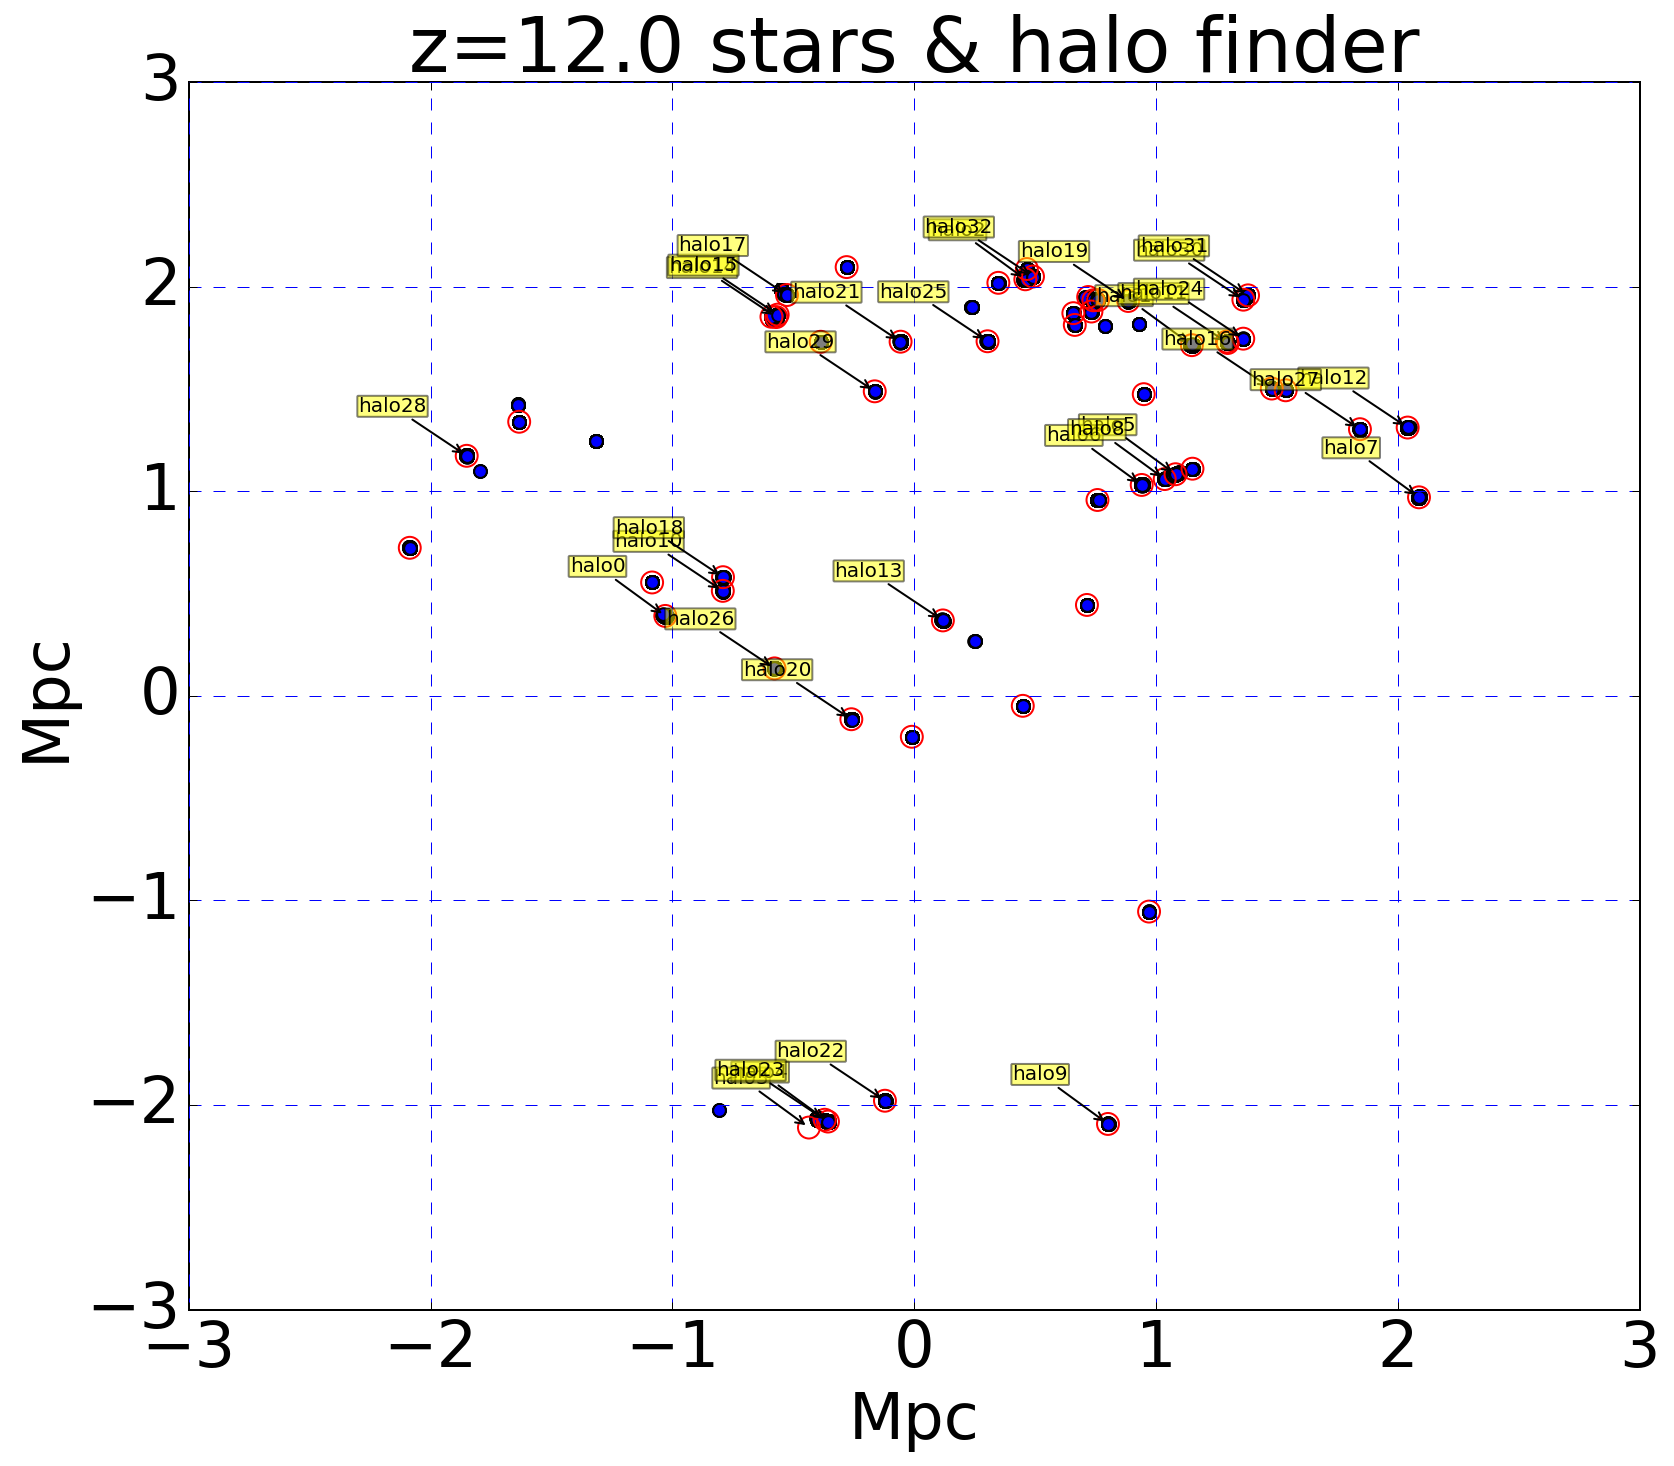

6245

In [17]:
htp = min(500,len(halosRawPos))
labels = ['halo{0}'.format(i) for i in range(len(halosPos))]
plt.scatter(locs[:,1]/1000,locs[:,2]/1000,s=40,c='b') # Plot star particles
plt.scatter(halosPos[:htp,1]/1000,halosPos[:htp,2]/1000,s=120,facecolors='none', edgecolors='r') # Plot halo locs
plt.grid(b=True, which='major', color='b', linestyle='--')
plt.xlabel('Mpc')
plt.ylabel('Mpc')
# plt.xlim([-2,2])
# plt.ylim([-2,2])
plt.title('z=%.1lf stars & halo finder'%z)
for label, x, y in zip(labels, halosPos[:htp,1][:33]/1000,halosPos[:htp,2][:33]/1000):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',fontsize=10,
        bbox = dict(boxstyle = 'round,pad=0.05', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
plt.show()
gc.collect()
 

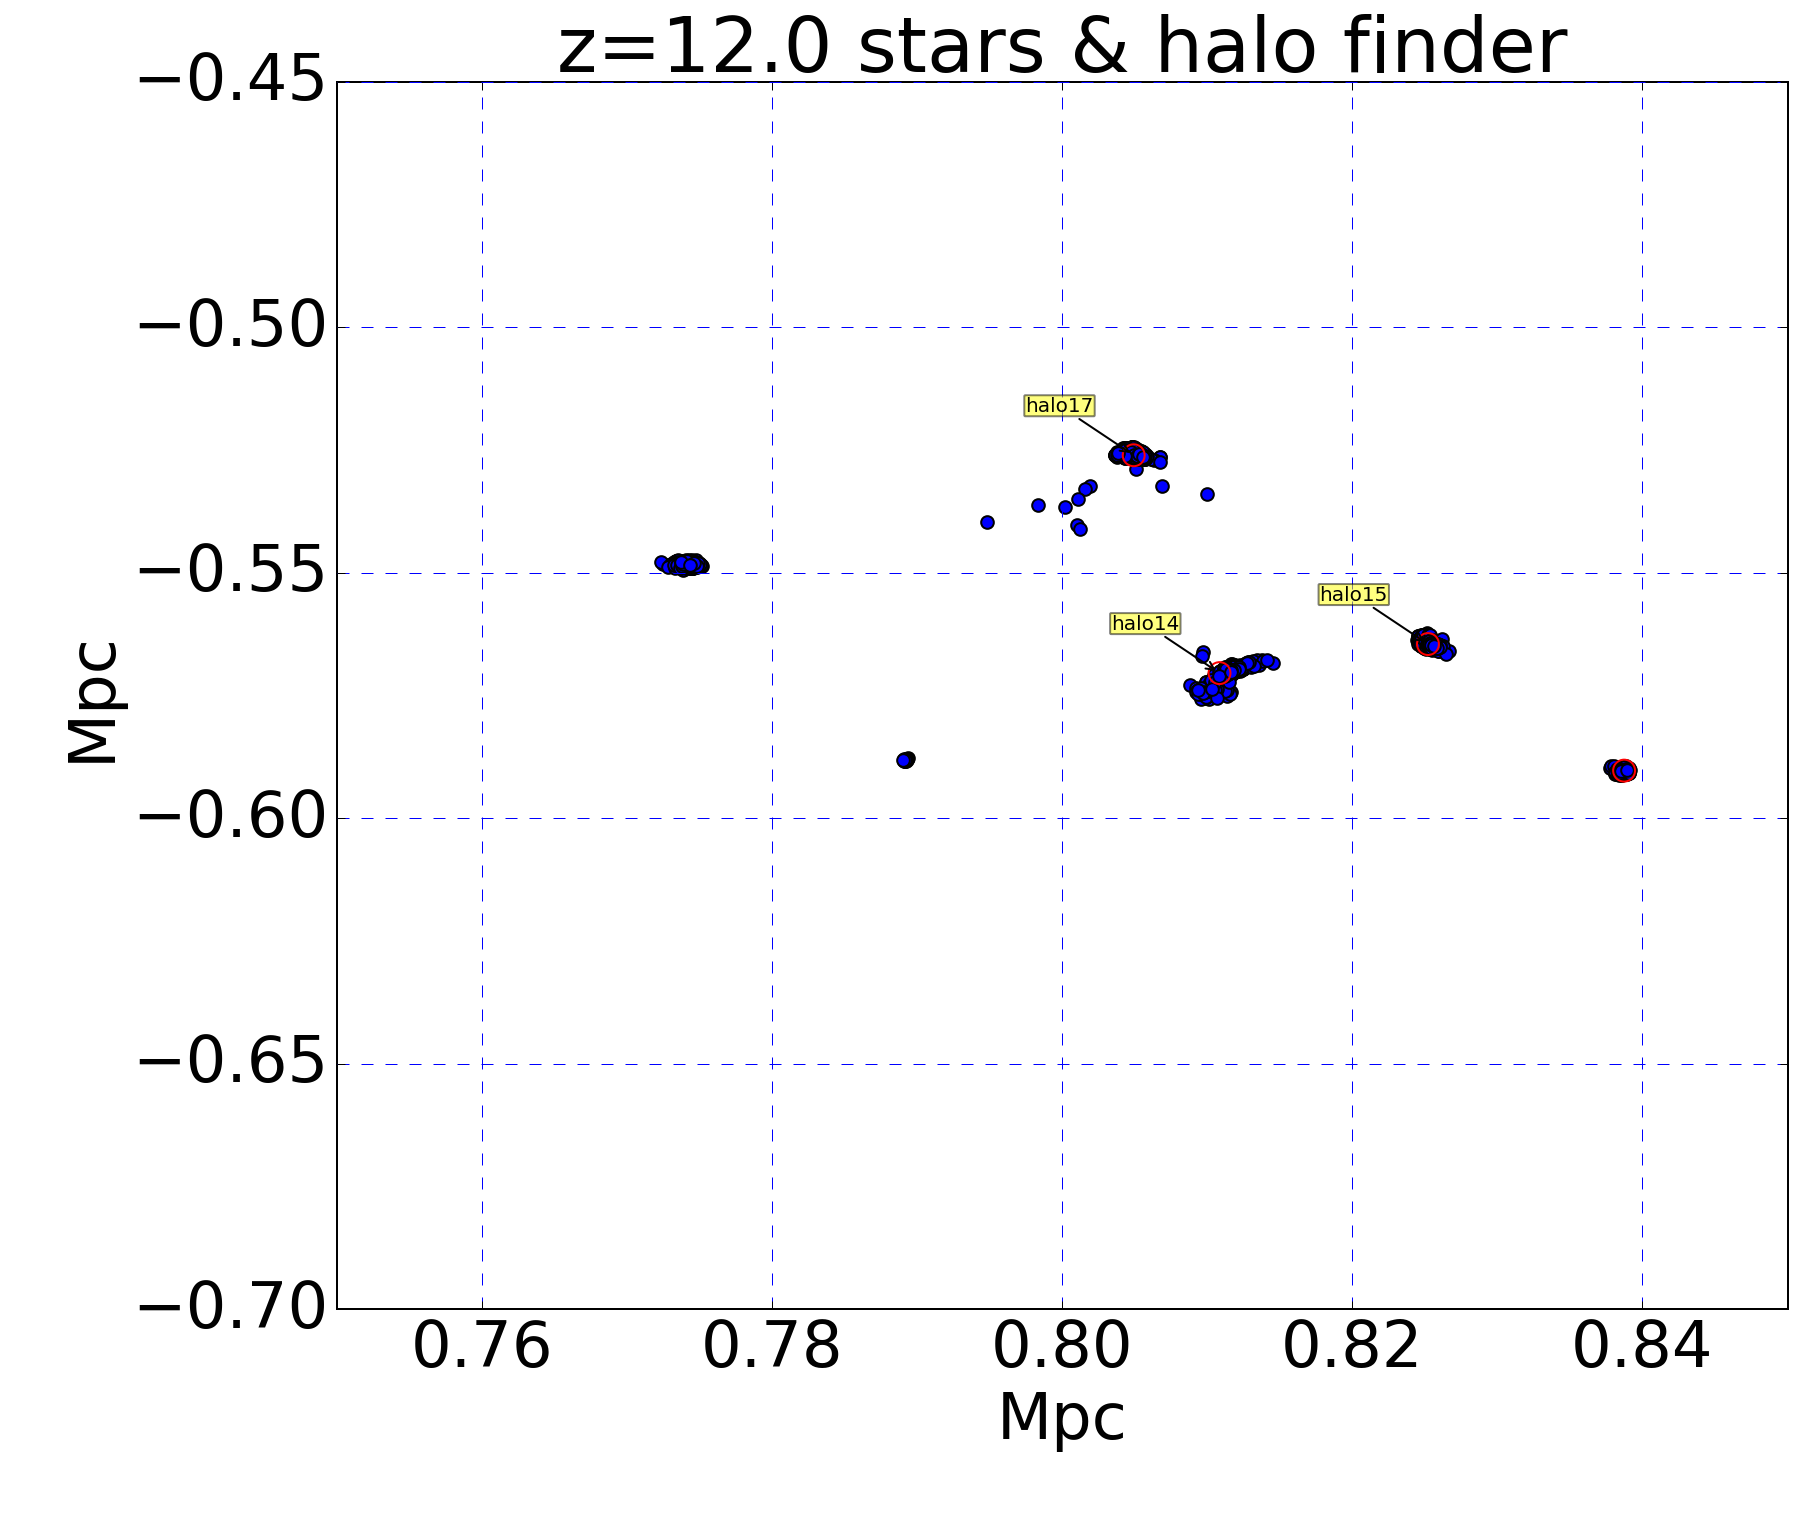

6071

In [18]:
# For 9.0 abandoned halo ... 
htp = len(halosRawPos)
labels = ['halo{0}'.format(i) for i in range(len(halosPos))]
plt.scatter(locs[:,0]/1000,locs[:,1]/1000,s=40,c='b') # Plot star particles
plt.scatter(halosPos[:htp,0]/1000,halosPos[:htp,1]/1000,s=120,facecolors='none', edgecolors='r') # Plot halo locs
plt.grid(b=True, which='major', color='b', linestyle='--')
plt.xlabel('Mpc')
plt.ylabel('Mpc')
plt.xlim([.68,.70])
plt.ylim([2.1,2.12])
plt.xlim([-1.55,-1.52])
plt.ylim([-0.36,-0.40])
plt.xlim([.75,0.85])
plt.ylim([-0.7,-0.45])
plt.title('z=%.1lf stars & halo finder'%z)
for label, x, y in zip(labels, halosPos[:htp,0][:33]/1000,halosPos[:htp,1][:33]/1000):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',fontsize=10,
        bbox = dict(boxstyle = 'round,pad=0.05', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
plt.show()
gc.collect()
 

radius 21.82
Halo mass 0 is 1.88e+07


49486

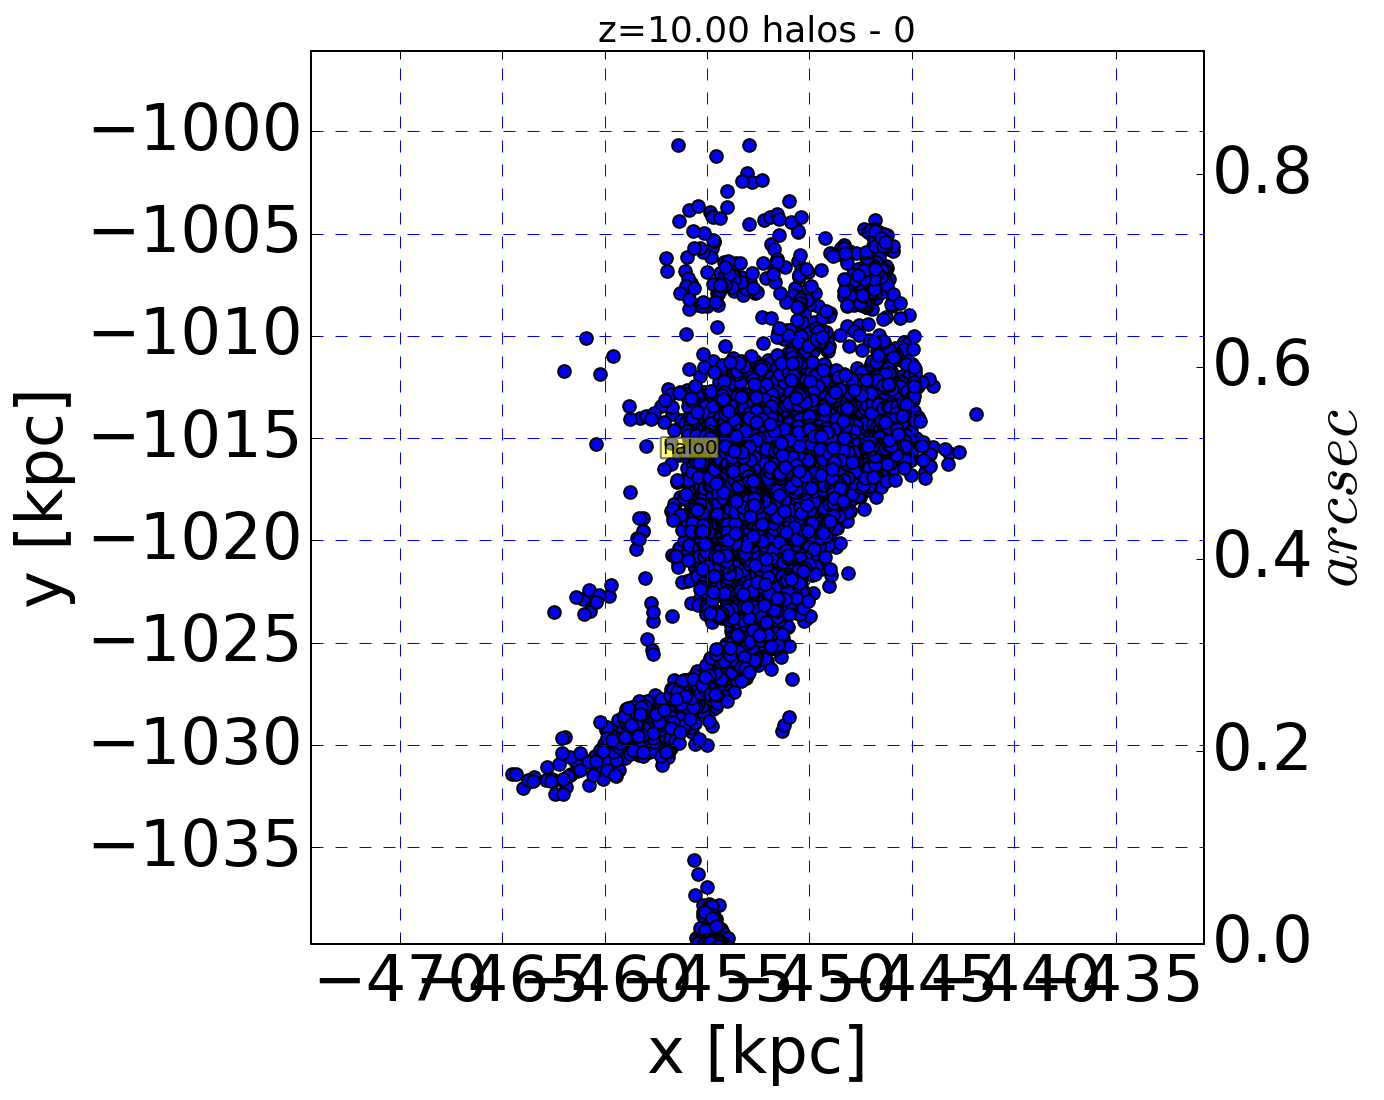

In [24]:
halo = 0
arcSec_per_kpc_comov = myCosmo.arcsec_per_kpc_comoving(z=z).value 
radiusScaleFac = 0.75
radius = ((totMass(halossizes['count'][halo]) * 3.0/(4.0 * ma.pi) * \
           1.0/(myCosmo.critical_density(z) * myCosmo.Odm(z) * 100 ))**(1.0/3.0)).to(u.kpc) * (1.0 * z)
radius = radius.value * radiusScaleFac
print('radius {:.2f}'.format(radius))

haloStars,halomass,haloages,haloZ,haloPZ,haloPPF = halos.getHaloStars(locs,mass,spAges,Z,PZ,PPF,
                                                                      halosPos,halo,r=radius)

print("Halo mass {} is {:.2e}".format(halo, np.sum(halomass)))
ax=halos.pltView(locs,halosPos,halo,z,radius * 2.0)
hax2 = ax.twinx()
hax2.set_ylim([0,radius * 2.0 * arcSec_per_kpc_comov])
hax2.set_ylabel(r'$arcsec$')
hax2.yaxis.labelpad = -3
del ax
gc.collect()

In [30]:
overDens = 100.0
radiusScaleFac = 0.75
print("z={}".format(z))
arcSec_per_kpc_comov = myCosmo.arcsec_per_kpc_comoving(z=z).value 
#for halo in range(len(halosRawPos)):
for halo in range(6):
    # Remember to compute radius in Comoving coords
    radius = ((totMass(halossizes['count'][halo]) * 3.0/(4.0 * ma.pi) * \
               1.0/(myCosmo.critical_density(z) * myCosmo.Odm(z) * overDens ))**(1.0/3.0)).to(u.kpc) * (1.0 * z)
    radius = radius.value * radiusScaleFac
    print('radius {:.2f}'.format(radius))
    haloStars,halomass,haloages,haloZ,haloPZ,haloPPF = halos.getHaloStars(locs,mass,spAges,Z,PZ,PPF,
                                                                          halosPos,halo,r=5)
    if len(halomass) == 0:
        print("SKipping {} since no sps at center...".format(halo))
        continue
    haloStars,halomass,haloages,haloZ,haloPZ,haloPPF = halos.getHaloStars(locs,mass,spAges,Z,PZ,PPF,
                                                                          halosPos,halo,r=radius)

    print("Halo mass {} is {:.2e}".format(halo, np.sum(halomass)))
    fig = plt.figure(figsize=(8,8))
    ax=halos.pltView(locs,halosPos,halo,z,radius * 2.0)
    hax2 = ax.twinx()
    hax2.set_ylim([0,radius * 2.0 * arcSec_per_kpc_comov])
    hax2.set_ylabel(r'$arcsec$')
    hax2.yaxis.labelpad = -3
    plt.savefig('/Volumes/ASU-2TB-Bay3/'+'galaxy_z_SP_{}_{}.png'.format(z,halo),dpi=fig.dpi,bbox_inches='tight')
    plt.clf()
    del ax
    gc.collect()

z=16.0
radius 7.01
Halo mass 0 is 5.35e+05
radius 6.17
Halo mass 1 is 3.87e+05
radius 5.83
Halo mass 2 is 3.31e+05
radius 4.90
Halo mass 3 is 1.91e+05
radius 4.85
Halo mass 4 is 1.79e+05
radius 3.44
Halo mass 5 is 6.55e+04


###### ax=halos.pltView(locs,halosPos,9,z,40) # x2 since size is full-fov ... size = 2xradius
hax2 = ax.twinx()
hax2.set_ylim([0,radius * 2.0 * arcSec_per_kpc_comov])
hax2.set_ylabel(r'$arcsec$')
hax2.yaxis.labelpad = -3
gc.collect()